# ⭐ DOCUMENT DETECTION - TRIPLET LOSS

# ![https://storage.prompt-hunt.workers.dev/clhza0ag4000hl60fz1tnwa4e_1](https://storage.prompt-hunt.workers.dev/clhza0ag4000hl60fz1tnwa4e_1)

# IMPORT REQUIRED LIBRARIES 🌧

In [39]:
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
from torch.optim import Adam,lr_scheduler
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.nn.parallel import DataParallel
from PIL import Image
import os
import pickle
import random
import time
import cv2

# MAKE INTO TRIPLETS ☘️

In [40]:
class Triplet:
    def __init__(self, train_folder):
        self.train_folder = train_folder
        self.labels = [label for label in os.listdir(train_folder) if label != '.ipynb_checkpoints']
        self.label_to_path = {label: os.path.join(train_folder, label) for label in self.labels}
    
    def get_triplet(self):
        anchor_label = random.choice(self.labels)
        anchor_path = random.choice(os.listdir(self.label_to_path[anchor_label]))
        positive_label = anchor_label
        positive_path = random.choice(os.listdir(self.label_to_path[positive_label]))
        negative_label = random.choice([label for label in self.labels if label != anchor_label])
        negative_path = random.choice(os.listdir(self.label_to_path[negative_label]))
        
        anchor_image = os.path.join(self.label_to_path[anchor_label], anchor_path)
        positive_image = os.path.join(self.label_to_path[positive_label], positive_path)
        negative_image = os.path.join(self.label_to_path[negative_label], negative_path)
        
        anchor_label_num = self.labels.index(anchor_label)
        positive_label_num = self.labels.index(positive_label)
        negative_label_num = self.labels.index(negative_label)
        
        return anchor_image, positive_image, negative_image

In [41]:
class TripletDataset(Dataset):
    def __init__(self, train_folder, length, transform=None,):
        self.triplet_generator = Triplet(train_folder)
        self.transform = transform
        self.length = length

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        anchor_image, positive_image, negative_image = self.triplet_generator.get_triplet()
        anchor = self._load_image(anchor_image)
        positive = self._load_image(positive_image)
        negative = self._load_image(negative_image)
        return anchor, positive, negative

    def _load_image(self, image_path):
        image = Image.open(image_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image

    def get_triplet_names(self, index):
        anchor_image, positive_image, negative_image = self.triplet_generator.get_triplet()
        return anchor_image, positive_image, negative_image

# DATALOADER ⏳

In [42]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])

In [43]:
bs = 128

train_folder = "./Datasets/RVL_CDIP/train/"
valid_folder = "./Datasets/RVL_CDIP/validation/"
test_folder = "./Datasets/RVL_CDIP/test/"

In [44]:
train_dataset = TripletDataset(train_folder, 320000, transform=transform, )
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

In [46]:
valid_dataset = TripletDataset(valid_folder, 40000, transform=transform, )
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=True)

In [45]:
test_dataset = TripletDataset(test_folder, 33669, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

# THE MODEL ✨

In [47]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 53 * 53, 256),
            nn.PReLU(),
            nn.Linear(256, 256),
            nn.PReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

In [48]:
emb = EmbeddingNet()

# TRIPLET WRAPPER ☘️

In [49]:
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2=None, x3=None):
        if x2 is None and x3 is None:
            return self.embedding_net(x1)
        return self.embedding_net(x1),self.embedding_net(x2),self.embedding_net(x3)

    def get_embedding(self, x):
        return self.embedding_net(x)

# TRIPLET LOSS 📈

In [50]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin
    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

# SET THE STUFFS UP  🚀

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TripletNet(emb)
model = nn.DataParallel(model)
model = model.to(device)
margin = 1
lr = 0.0001
n_epochs = 3
optimizer = Adam(model.parameters(), lr=lr)
loss_fn = TripletLoss(margin)

# EVALUATING

In [52]:
def evaluate_model(model, triplet_test_loader,for_log=False,LIMIT=None):
    model.eval()
    correct = 0
    total = 0
    start = time.time()
    with torch.no_grad():
        for idx,(anchor, positive, negative) in enumerate(triplet_test_loader):
            if for_log and idx==LIMIT:
                return f'ACCURACY: {correct/total*100}% ,TIME: {time.time()-start}'
            anchor_embedding, positive_embedding, negative_embedding = model(anchor.to(device),
                                                                             positive.to(device),
                                                                             negative.to(device))
            distance_positive = torch.norm(anchor_embedding - positive_embedding, dim=1).to(device)
            distance_negative = torch.norm(anchor_embedding - negative_embedding, dim=1).to(device)
            correct += torch.sum(distance_positive < distance_negative).item()
            total += anchor.size(0)
    accuracy = correct / total
    print(accuracy*100,time.time()-start)

# TRAIN 🦜

In [15]:
def fit(model, num_epochs, train_loader,bs):
    for epoch in range(n_epochs):
        start = time.time()
        model.train()
        train_loss = 0.0
        for idx, batch in enumerate(train_loader):
            anchor, positive, negative = batch
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            optimizer.zero_grad()
            anchor_embedding, positive_embedding, negative_embedding = model(anchor, positive, negative)
            anchor_embedding.requires_grad_(True)
            positive_embedding.requires_grad_(True)
            negative_embedding.requires_grad_(True)
            loss = loss_fn(anchor_embedding, positive_embedding, negative_embedding)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            print(f"({idx + 1}).  LOSS : {loss.item()}  SEEN : {bs * (idx + 1)}/{len(train_loader.dataset)}")
            break
        print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, TIME: {time.time()-start}")
        val_log = evaluate_model(model, valid_loader,for_log=True,LIMIT=500)
        print(f"VALIDATION LOG : {val_log}")
        test_log = evaluate_model(model, test_loader,for_log=True,LIMIT=500)
        print(f"TEST LOG : {test_log}")

In [ ]:
fit(model,n_epochs,train_loader,bs)

# EVALUATE THE MODEL ⚖️

In [102]:
evaluate_model(model,test_loader)

88.19982773471146 178.2334017753601


In [18]:
evaluate_model(model,valid_loader)

87.63250000000001 237.55444431304932


In [53]:
model_path = './Models/model-rvl_cdip.pth'
#torch.save(model.state_dict(), model_path)

In [14]:
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)

<All keys matched successfully>

# WITH FAISS

In [54]:
import faiss

In [55]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_paths = []
        self.labels = []

        self._load_images()

    def _load_images(self):
        valid_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
        for class_name in os.listdir(self.folder_path):
            class_folder = os.path.join(self.folder_path, class_name)
            if os.path.isdir(class_folder):
                for filename in os.listdir(class_folder):
                    if filename.lower().endswith(valid_extensions):
                        self.image_paths.append(os.path.join(class_folder, filename))
                        self.labels.append(class_name)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

In [59]:
train_folder = "./Datasets/RVL_CDIP/train"
test_folder = "./Datasets/RVL_CDIP/test"
test_dataset = CustomDataset(test_folder, transform=transform)
test_dataloader = DataLoader(test_dataset, shuffle=True)
train_dataset = CustomDataset(train_folder, transform=transform)
train_dataloader = DataLoader(train_dataset, shuffle=True)
valid_dataset = CustomDataset(valid_folder, transform=transform)
valid_dataloader = DataLoader(valid_dataset)

In [ ]:
train_embs = None
train_labels = []
for idx,i in enumerate(train_dataloader):
    print(idx)
    I, L = i
    train_labels.append(L)
    emb = model(I) # Assuming `model_loaded(I)` returns a PyTorch tensor
    emb = emb.detach()
    if train_embs is None:
        train_embs = emb
    else:
        train_embs = torch.cat((train_embs, emb), dim=0)

In [ ]:
test_embs = None
test_labels = []
for idx,i in enumerate(test_dataloader):
    print(idx)
    I, L = i
    test_labels.append(L)
    emb = model(I) # Assuming `model_loaded(I)` returns a PyTorch tensor
    emb = emb.detach()
    if test_embs is None:
        test_embs = emb
    else:
        test_embs = torch.cat((test_embs, emb), dim=0)

In [ ]:
valid_embs = None
valid_labels = []
for idx,i in enumerate(valid_dataloader):
    if idx%1000==0:
        print(idx)
    I, L = i
    valid_labels.append(L)
    emb = model(I) # Assuming `model_loaded(I)` returns a PyTorch tensor
    emb = emb.detach()
    if valid_embs is None:
        valid_embs = emb
    else:
        valid_embs = torch.cat((valid_embs, emb), dim=0)

In [97]:
len(valid_labels)

40000

In [98]:
with open('./Pickles/valid_embeddings.pkl', 'wb') as f:
    pickle.dump(valid_embs, f)

with open('./Pickles/valid_labels.pkl', 'wb') as f:
    pickle.dump(valid_labels, f)

In [99]:
with open('./Pickles/train_embeddings.pkl', 'rb') as f:
    train_embs = pickle.load(f)

with open('./Pickles/test_embeddings.pkl', 'rb') as f:
    test_embs = pickle.load(f)

with open('./Pickles/valid_embeddings.pkl', 'rb') as f:
    valid_embs = pickle.load(f)

with open('./Pickles/train_labels.pkl', 'rb') as f:
    train_labels = pickle.load(f)

with open('./Pickles/test_labels.pkl', 'rb') as f:
    test_labels = pickle.load(f)
    
with open('./Pickles/valid_labels.pkl', 'rb') as f:
    valid_labels = pickle.load(f)

In [100]:
len(valid_labels)

40000

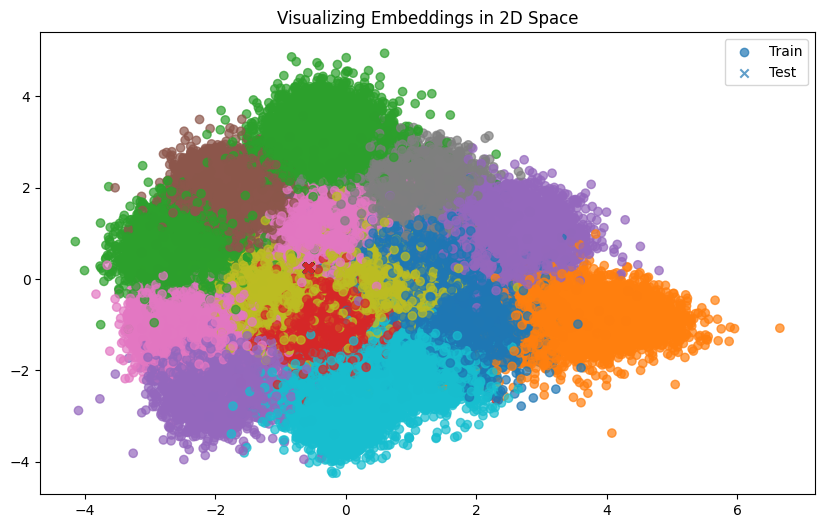

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_embeddings(train_embs, test_embs, labels1, labels2):
    all_embs = np.vstack((train_embs, test_embs))
    all_labels = labels1 + labels2
    pca = PCA(n_components=2)
    projected_embs = pca.fit_transform(all_embs)
    train_projected = projected_embs[:len(train_embs)]
    test_projected = projected_embs[len(train_embs):]
    plt.figure(figsize=(10, 6))
    plt.scatter(train_projected[:, 0], train_projected[:, 1], c=labels1, cmap='tab10', label='Train', alpha=0.7)
    plt.scatter(test_projected[:, 0], test_projected[:, 1], c=labels2, cmap='tab10', marker='x',label='Test', alpha=0.7)
    plt.legend()
    plt.title('Visualizing Embeddings in 2D Space')
    plt.show()

labels1 = train_labels
labels2 = test_labels

visualize_embeddings(train_embs.cpu(), valid_embs.cpu(), train_labels, valid_labels)

# ![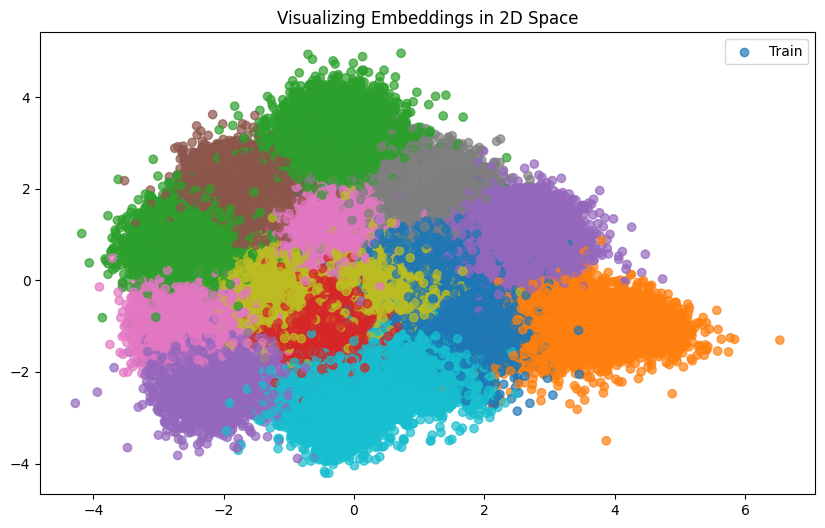](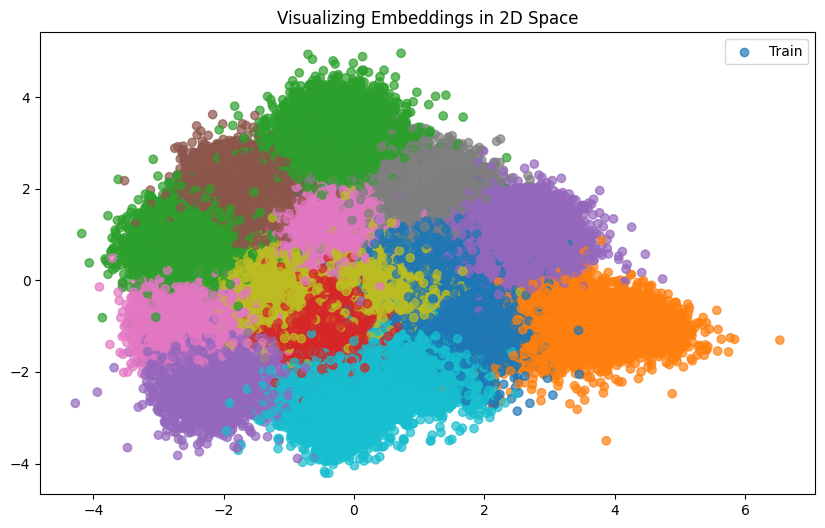)

# ![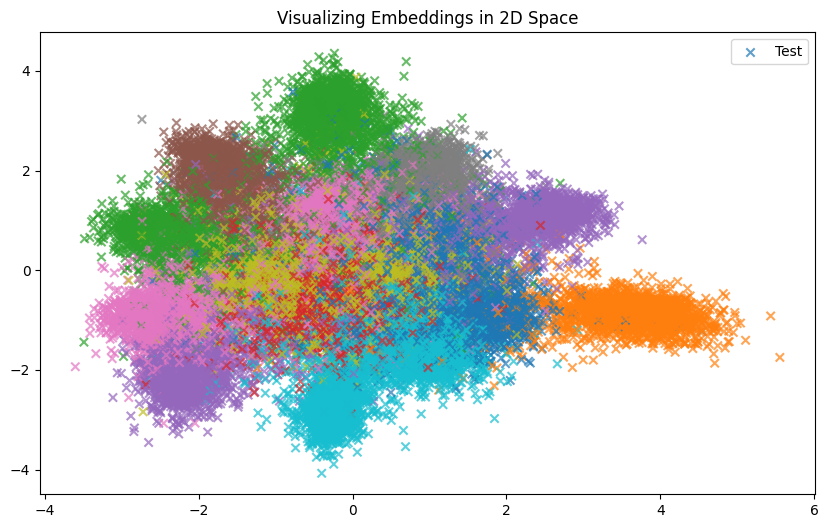](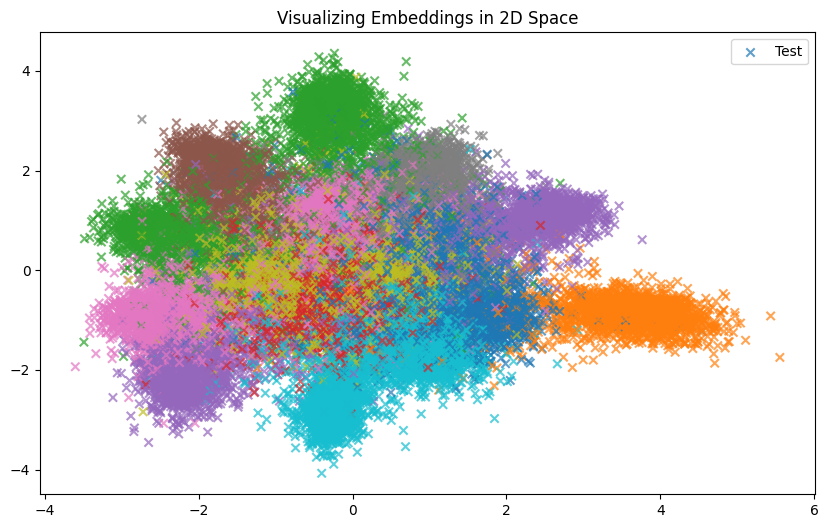)

In [104]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

def kmeans_clustering(train_embs, test_embs, labels1, labels2, num_clusters):
    all_embs = np.vstack((train_embs, test_embs))
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(all_embs)
    train_cluster_labels = cluster_labels[:len(train_embs)]
    test_cluster_labels = cluster_labels[len(train_embs):]
    
    labels1 = np.array(labels1, dtype=np.int)
    labels1 = labels1.flatten()
    
    cluster_to_label = {}
    for cluster_id in range(num_clusters):
        cluster_samples = labels1[train_cluster_labels == cluster_id]
        label_counts = np.bincount(cluster_samples)
        cluster_to_label[cluster_id] = np.argmax(label_counts)
    
    predicted_labels = np.array([cluster_to_label[cluster_id] for cluster_id in test_cluster_labels])
    
    # Convert labels2 to the appropriate format (np.array)
    labels2 = np.array(labels2, dtype=np.int)
    
    acc = accuracy_score(labels2, predicted_labels)
    return acc

num_clusters = 16
accuracy = kmeans_clustering(train_embs.cpu(), valid_embs.cpu(), train_labels, valid_labels, num_clusters)
print(f"Accuracy using k-means clustering: {accuracy:.2f}")


In [72]:
import faiss

In [ ]:
embs = train_embs.cpu().numpy()
index1 = faiss.IndexFlatL2(embs.shape[1])  # Assuming embs.shape[1] represents the dimensionality of the embeddings
index1.add(embs_cpu_np)

nlist = 100  # Number of cells/buckets
quantizer = faiss.IndexFlatL2(embs.shape[1])  # Quantizer index (same as IndexFlatL2)
index2 = faiss.IndexIVFFlat(quantizer, embs.shape[1], nlist)
index2.train(embs_cpu_np)
index2.add(embs_cpu_np)

index3 = faiss.IndexHNSWFlat(embs.shape[1], 128)  # M = 32 for the HNSW index
index3.add(embs_cpu_np)

nbits = 8  # Number of bits for the LSH hash
index4 = faiss.IndexLSH(embs.shape[1], nbits)
index4.add(embs_cpu_np)

In [115]:
def evaluatewithfaiss(embs,index):
    TOTAL = len(embs)
    CORRECT = 0
    start = time.time()
    for idx,emb in enumerate(embs):
        label = index.search(emb.reshape(1,-1),1)[1][0][0]
        if int(train_labels[label][0])==int(train_labels[idx][0]):
            CORRECT += 1
    return f'{CORRECT}/{TOTAL}={(CORRECT/TOTAL)*100}',f'TIME = {time.time()-start} SECONDS'

In [112]:
embs2_cpu_np = train_embs.cpu().numpy()

In [118]:
len(valid_embs)

40000

In [119]:
#print(f'IndexFlatL2 : {evaluatewithfaiss(embs2_cpu_np,index1)}')
print(f'IndexIVFFlat : {evaluatewithfaiss(embs2_cpu_np,index2)}')
print(f'IndexHNSWFlat : {evaluatewithfaiss(embs2_cpu_np,index3)}')
#print(f'IndexLSH : {evaluatewithfaiss(embs2_cpu_np,index4)}')

IndexIVFFlat : ('319751/320000=99.9221875', 'TIME = 5.327977180480957 SECONDS')
IndexHNSWFlat : ('319754/320000=99.923125', 'TIME = 11.636978387832642 SECONDS')
